In [1]:
# Author: Anthony ma
# Date: 05/6/18

import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from lifelines import *
from lifelines.statistics import logrank_test

def process_data(input):
    """
    Basic statistical profiling 
    
    Parameters
    ----------
    input: string
        Input data file path 
        
    """
    df = pd.read_csv(input, delimiter="\t")
    return df


def var_dist(df, var, df_var_name, plot_title):
    """
    Extract statistics and plot distribution of race 
    
    Parameters
    ----------
    df: pandas data frame 
        Dataframe object to profile
    var: string
        User defined variable name 
    
    df_var_name: string
        Column header name as specified in the raw data
    plot_title: string
        Title to name the plot 
    """
    
    # plot race distribution
    df_var = df[df_var_name]
    var_count = df_var.value_counts()
    var_count_dict = var_count.to_dict()
    var_count.plot(kind='bar', color='Black', title=plot_title)
    
    # calculate race distribution
    print("\n%s distribution" % (var))
    n = sum(var_count_dict.values())
    for k, v in var_count_dict.iteritems():
        percentage_dist = round(100*float(v)/n, 1)
        print "%s, %s (%s)" % (k, percentage_dist, v)
    
    
### Survival Analysis Stratified by variables 
from scipy.stats import ttest_ind

def pairwise_ttest(df, var):
    """
    Perform pairwise log rank tests upon a specified variable
    
    Parameters
    ----------
    df: pandas DataFrame object
    var: string
        Name of column variable
    """
    
    var_types = df[var].unique()
    var_count_dict = df[var].value_counts().to_dict()
    
    var_type_pairwise_combo = []
    for combo in itertools.combinations(var_count_dict.keys(),2):
        var_type_pairwise_combo.append(combo)

    for vt1, vt2 in var_type_pairwise_combo:
        print("\n\nPerforming t-test for var = %s, %s vs %s " % (var, vt1, vt2))
        data_slice1 = (df[var] == vt1)
        data_slice2 = (df[var] == vt2)
        test_stat, p_val = ttest_ind(data_slice1, data_slice2)
        print ("test_stat: %s    p_val: %s" % (test_stat, p_val))


def pairwise_logrank(df, var):
    """
    Perform pairwise log rank tests upon a specified variable
    
    Parameters
    ----------
    df: pandas DataFrame object
    var: string
        Name of column variable
    """
    
    var_types = df[var].unique()
    var_count_dict = df[var].value_counts().to_dict()
    
    var_type_pairwise_combo = []
    for combo in itertools.combinations(var_count_dict.keys(),2):
        var_type_pairwise_combo.append(combo)

    for vt1, vt2 in var_type_pairwise_combo:
        print("\n\nPerforming logrank significance test for var = %s, %s vs %s " % (var, vt1, vt2))
        data_slice1 = (df[var] == vt1)
        data_slice2 = (df[var] == vt2)
        results = logrank_test(data_slice1, data_slice2, alpha=0.99)
        results.print_summary()


def pairwise_KM(df, var, row, col):
    """
    Perform pairwise kaplan meyer plotting upon a specified variable
    
    Parameters
    ----------
    df: pandas DataFrame object
    var: string
        Name of column variable
    row: int
        Number of rows of kaplan meyer graphs
    col: int
        Number of cols of kaplan meyer graphs
    """
    survival_months = df["Survival months"]
    var_types = df[var].unique()
    var_count_dict = df[var].value_counts().to_dict()
    kmf = KaplanMeierFitter()
    
    for i, var_type in enumerate(var_types):
        ax = plt.subplot(row, col, i+1)
        ix = df[var] == var_type 
        kmf.fit(survival_months[ix], label=var_type)
#         kmf.plot(ax=ax, legend=False)
        kmf.survival_function_.plot(ax=ax, legend=False)
        plt.title(var_type)
        print("%s (n = %s) -- %s (months) survival" % (var_type, var_count_dict[var_type], kmf.median_))
        if i==0:
            plt.ylabel('Percentage alive in $n$ months')
    plt.tight_layout()

    

def overlay_KM(df, var, title=""):
    """
    Overlay all kaplan meyer plotting upon a specified variable
    
    Parameters
    ----------
    df: pandas DataFrame object
        Input data set 
    var: string
        Name of column variable
    """
    
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    var_types = df[var].unique()
    var_types
    var_count_dict = df[var].value_counts().to_dict()
    
    survival_months = df['Survival months']

    for i, var_type in enumerate(var_types):
        ix = df[var] == var_type 
        print ix
        kmf.fit(survival_months[ix], label=var_type)
#         kmf.plot(ax=ax)
        kmf.survival_function_.plot(ax=ax)
    plt.ylabel("Survival")
    plt.title(title)
    
def compare_survival_outcomes(group1_df, group2_df, label1, label2, title=""):
    """
    Compares survival outcomes for two populations however
    user decides to stratify the data (ie with chemo vs without)
    
    Input:
    - group1_df Is the dataframe for first group
    - group2_df Is the dataframe for second group
    - label1 String label for group1
    - label2 String label for group2
    
    Output:
    - Overlayed Kaplan Meyer Curve
    - logrank significance test for the variable 
    - Median survival in each group
    """
    
    n_group1 = len(group1_df)
    n_group2 = len(group2_df)
    
    # logrank significance test - p_val
    group1_survival_months = group1_df['Survival months']
    group2_survival_months = group2_df['Survival months']
    results = logrank_test(group1_survival_months, group2_survival_months, alpha=0.99)
    results.print_summary()
    
    # Kaplan Meyer
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    
    kmf.fit(group1_survival_months, label=label1)
    median_group1_survival = kmf.median_
    kmf.survival_function_.plot(ax=ax, color="black")
    
    kmf.fit(group2_survival_months, label=label2)
    median_group2_survival = kmf.median_
    kmf.survival_function_.plot(ax=ax, color="gray")
    
    plt.title(title)
    
    print("\n\nMedian Survival -- %s: %s (n=%s)" % (label1, median_group1_survival, n_group1))
    print("Median Survival -- %s: %s (n=%s)" % (label2, median_group2_survival, n_group2))
    
    



In [90]:
medulloblastoma_data = "/Users/anthony/Desktop/sherlock/SEER/data/medulloblastoma/v1/medulloblastoma_v1.tsv"

In [149]:
### Medulloblastoma analysis
# n = 857 patients with survival outcome data

cdf = process_data(medulloblastoma_data)
cdf = cdf.loc[cdf['Survival months'] != 'Unknown']
cdf.head(200)

,Age at diagnosis,Sex,"Race recode (W, B, AI, API)",Year of diagnosis,Primary Site,Site specific surgery (1973-1997 varying detail by year and site),Site recode ICD-O-3/WHO 2008,Behavior recode for analysis,Primary Site - labeled,Histologic Type ICD-O-3,...,Radiation sequence with surgery,"Chemotherapy recode (yes, no/unk)",COD to site recode,SEER cause-specific death classification,Survival months,Reason no cancer-directed surgery,Vital status recode (study cutoff used),Total number of in situ/malignant tumors for patient,Total number of benign/borderline tumors for patient,Insurance Recode (2007+)
0,31,Male,White,1974,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,Radiation after surgery,No/Unknown,State DC not available or state DC available b...,Alive or dead of other cause,0019,Surgery performed,Dead,1,0,Blank(s)
1,40,Female,White,1979,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9471,...,Radiation after surgery,No/Unknown,Accidents and Adverse Effects,Alive or dead of other cause,0297,Surgery performed,Dead,1,0,Blank(s)
2,25,Female,Black,1978,716,09,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,No radiation and/or cancer-directed surgery,No/Unknown,Brain and Other Nervous System,Dead (attributable to this cancer dx),0432,"Recommended but not performed, unknown reason",Dead,1,0,Blank(s)
3,35,Male,Black,1980,716,09,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,No radiation and/or cancer-directed surgery,No/Unknown,Brain and Other Nervous System,Dead (attributable to this cancer dx),0004,"Recommended but not performed, unknown reason",Dead,1,0,Blank(s)
4,50,Male,Asian or Pacific Islander,1984,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,Radiation after surgery,No/Unknown,Brain and Other Nervous System,N/A not first tumor,0016,Surgery performed,Dead,2,0,Blank(s)
5,33,Female,White,1980,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,Radiation after surgery,Yes,Brain and Other Nervous System,Dead (attributable to this cancer dx),0013,Surgery performed,Dead,1,0,Blank(s)
6,21,Male,Black,1978,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,No radiation and/or cancer-directed surgery,No/Unknown,Brain and Other Nervous System,Dead (attributable to this cancer dx),0001,Surgery performed,Dead,1,0,Blank(s)
7,29,Female,White,1975,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,Radiation after surgery,No/Unknown,Breast,Alive or dead of other cause,0162,Surgery performed,Dead,2,0,Blank(s)
8,23,Male,White,1974,716,09,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,No radiation and/or cancer-directed surgery,No/Unknown,Brain and Other Nervous System,Dead (attributable to this cancer dx),0050,"Recommended but not performed, unknown reason",Dead,1,0,Blank(s)
9,86,Female,Asian or Pacific Islander,1976,716,90,Brain,Malignant,"C71.6-Cerebellum, NOS",9470,...,Radiation after surgery,No/Unknown,Pneumonia and Influenza,Alive or dead of other cause,0008,Surgery performed,Dead,1,0,Blank(s)



df=1, alpha=0.99, t_0=-1, null_distribution=chi squared

test_statistic      p     
       16.4199 0.0001  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


Median Survival -- Cerebellum (63.0 months - n=785): 63.0 (n=785)
Median Survival -- Non-Cerebellum (37.0 months - n=72): 37.0 (n=72)


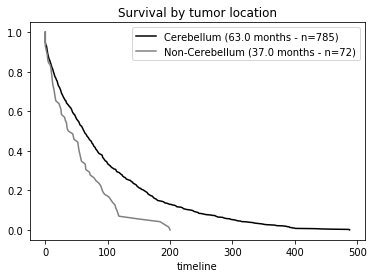

In [151]:
### Compare survival between cerebellar and non_cerebellar tumor sites
var = 'Primary Site - labeled'

cerebellar_df = cdf.loc[cdf[var] == 'C71.6-Cerebellum, NOS']
noncerebellar_df = cdf.loc[cdf[var] != 'C71.6-Cerebellum, NOS']

compare_survival_outcomes(cerebellar_df, noncerebellar_df, "Cerebellum (63.0 months - n=785)", "Non-Cerebellum (37.0 months - n=72)", "Survival by tumor location")


df=1, alpha=0.99, t_0=-1, null_distribution=chi squared

test_statistic      p     
       16.4583 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


Median Survival -- + chemo (54.0 mos - n=384): 54.0 (n=384)
Median Survival -- - chemo (67.0 mos - n=473): 67.0 (n=473)


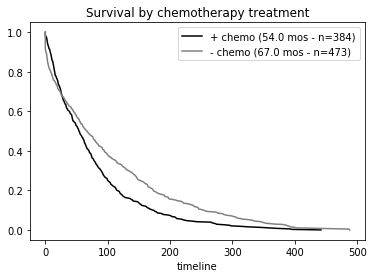

In [201]:
### Compare survival based on chemotherapy 
var = 'Chemotherapy recode (yes, no/unk)'
withchemo_bool = cdf[var] == 'Yes'
nochemo_bool = cdf[var] == 'No/Unknown'
withchemo_df = cdf.loc[withchemo_bool]
nochemo_df = cdf.loc[nochemo_bool]

compare_survival_outcomes(withchemo_df, nochemo_df, "+ chemo (54.0 mos - n=384)", "- chemo (67.0 mos - n=473)", "Survival by chemotherapy treatment")

['Radiation after surgery' 'No radiation and/or cancer-directed surgery'
 'Sequence unknown, but both were given' 'Radiation prior to surgery'
 'Radiation before and after surgery'
 'Intraoperative rad with other rad before/after surgery']

df=1, alpha=0.99, t_0=-1, null_distribution=chi squared

test_statistic      p     
       27.7745 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


Median Survival -- + rad (65.0 mos - n=689): 65.0 (n=689)
Median Survival -- - rad (25.0 mos - n=168): 25.0 (n=168)


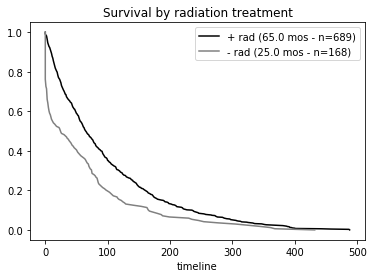

In [200]:
### Compare survival based on radiation 
var = 'Radiation sequence with surgery'
print cdf[var].unique()
withrad_bool = (cdf[var] == 'Radiation after surgery') | (cdf[var] == 'Sequence unknown, but both were given') | (cdf[var] == 'Radiation prior to surgery') | (cdf[var] == 'Radiation before and after surgery') | (cdf[var] == 'Intraoperative rad with other rad before/after surgery')
norad_bool = (cdf[var] == 'No radiation and/or cancer-directed surgery')
withrad_df = cdf.loc[withrad_bool]
norad_df = cdf.loc[norad_bool]

compare_survival_outcomes(withrad_df, norad_df, "+ rad (65.0 mos - n=689)", "- rad (25.0 mos - n=168)", "Survival by radiation treatment")


df=1, alpha=0.99, t_0=-1, null_distribution=chi squared

test_statistic      p    
        7.3753 0.0066  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


Median Survival -- + surg (62.0 mos - n=815): 62.0 (n=815)
Median Survival -- - surg (25.0 mos - n=42): 25.0 (n=42)


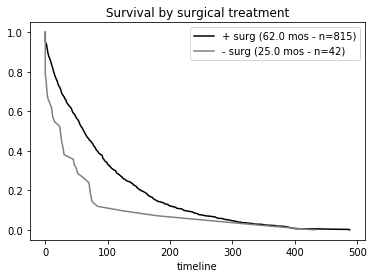

In [199]:
### Compare survival based on surgery
var = 'Reason no cancer-directed surgery'
withsurgery_bool = (cdf[var] == 'Surgery performed')
nosurgery_bool = (cdf[var] != 'Surgery performed')
# nosurgery_bool = (cdf[var] == 'Recommended but not performed, unknown reason') | (cdf[var] == 'Unknown; death certificate; or autopsy only (2003+)') | (cdf[var] == 'Not recommended') | (cdf[var] == 'Not recommended, contraindicated due to other cond; autopsy only (1973-2002)') | (cdf[var] == 'Recommended but not performed, patient refused')
withsurgery_df = cdf.loc[withsurgery_bool]
nosurgery_df = cdf.loc[nosurgery_bool]
compare_survival_outcomes(withsurgery_df, nosurgery_df, "+ surg (62.0 mos - n=815)", "- surg (25.0 mos - n=42)", "Survival by surgical treatment")



df=1, alpha=0.99, t_0=-1, null_distribution=chi squared

test_statistic      p     
       22.7417 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


Median Survival -- + surg + rad (66.0 mos - n=687): 66.0 (n=687)
Median Survival -- + surg - rad (34.0 mos - n=128): 34.0 (n=128)


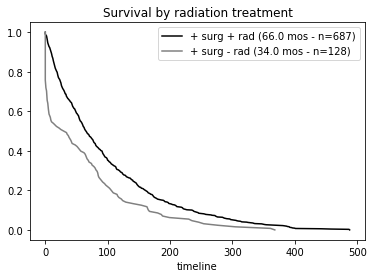

In [202]:
# Integrating Jacky's 05/06/18 Manuscript comments
# Surgery only vs Surgery + Rad vs Rad only, with and without chemo in all. 6 curves

withsurgery_norad_bool = withsurgery_bool & norad_bool
withsurgery_norad_df = cdf.loc[withsurgery_norad_bool]

withsurgery_withrad_bool = withsurgery_bool & withrad_bool
withsurgery_withrad_df = cdf.loc[withsurgery_withrad_bool]
compare_survival_outcomes(withsurgery_withrad_df, withsurgery_norad_df, "+ surg + rad (66.0 mos - n=687)", "+ surg - rad (34.0 mos - n=128)", "Survival by radiation treatment")


+ surg + rad + chemo (55.0 mos - n=355) 55.0
+ surg + rad - chemo (90.0 mos - n=332) 90.0
+ surg - rad + chemo (43.0 mos - n=16) 43.0
+ surg - rad - chemo (25.0 mos - n=112) 25.0
- surg + rad + chemo (29.0 mos - n=2) 29.0
- surg - rad + chemo (25.0 mos - n=11) 25.0
- surg - rad - chemo (12.0 mos - n=29) 12.0


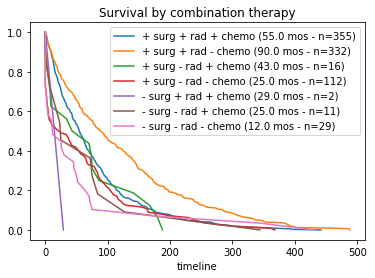

In [197]:
# Including chemo 
def multi_compare_survival_outcome(groups, labels, medians, title=""):
    ax = plt.subplot(111)
    kmf = KaplanMeierFitter()
    for idx, g in enumerate(groups):
        g_df = g['Survival months']
        n = len(g_df)
        label = labels[idx] + " (%s mos - n=%d)" % (medians[idx], n)
        kmf.fit(g_df, label=label)
        print label, kmf.median_
        kmf.survival_function_.plot(ax=ax)
    plt.title(title)

withsurgery_withrad_withchemo = cdf.loc[withsurgery_withrad_bool & withchemo_bool]
withsurgery_withrad_nochemo = cdf.loc[withsurgery_withrad_bool & nochemo_bool]
withsurgery_norad_withchemo = cdf.loc[withsurgery_norad_bool & withchemo_bool]
withsurgery_norad_nochemo = cdf.loc[withsurgery_norad_bool & nochemo_bool]

nosurgery_withrad_withchemo = cdf.loc[nosurgery_bool & withrad_bool & withchemo_bool]
# nosurgery_withrad_nochemo = cdf.loc[nosurgery_bool & withrad_bool & nochemo_bool]
nosurgery_norad_withchemo = cdf.loc[nosurgery_bool & norad_bool & withchemo_bool]
nosurgery_norad_nochemo = cdf.loc[nosurgery_bool & norad_bool & nochemo_bool]



groups = [withsurgery_withrad_withchemo, withsurgery_withrad_nochemo, withsurgery_norad_withchemo, withsurgery_norad_nochemo]
groups.append(nosurgery_withrad_withchemo)
# groups.append(nosurgery_withrad_nochemo)
groups.append(nosurgery_norad_withchemo)
groups.append(nosurgery_norad_nochemo)

labels = ["+ surg + rad + chemo", "+ surg + rad - chemo", "+ surg - rad + chemo", "+ surg - rad - chemo"]
labels.append("- surg + rad + chemo")
# labels.append("nosurgery_withrad_nochemo")
labels.append("- surg - rad + chemo")
labels.append("- surg - rad - chemo")

medians = ["55.0", "90.0", "43.0", "25.0", "29.0", "25.0", "12.0"]

multi_compare_survival_outcome(groups, labels, medians, title="Survival by combination therapy")

# withsurgery_withrad_withchemo.head(200)
